# Path finding in environment with obstacles using Markov Decision Processes

This notebook represents a solution to a problem, where a drone should fly through the cave with obstacles (stalagmites and stalactites) and safely arrive at finish point. The task is a path finding problem in a **fully observable** environment, where **Markov Decision Processes** are used to describe the problem and **Value Iteration** algorithm is used to solve the problem. The notebook shows interactively solutions for differently hyperparameters values, allowing to see what happens if we tweak with some of the hyperparameters and describes observed results. 

Contents:

- MDP classes 
- Value Iteration algorithm
- Results with visualizations


In [3]:
from mdp import MDP, GridMDP
from mdp import value_iteration, best_policy, expected_utility
from visualization import GridMDPVisualizer, InteractivePlot
from utils import grid_1
from notebook import print_source

# MDP class

TODO:
- describe what is in this section
- describe here what structure should an MDP class to have
- how it is used

In this section are shown MDP classes, which are used to represent a pathfinding problem as Markov Decision Process, store important data and give important interface.

There is a base class - MDP, from which we have derived class GridMDP to work with 2D environment of the cave with obstacles.

The MDP class does not have algorithm part for solution, it is a mere data class to encode problem into MDP representation and then give convenient access.

To encode problem into MDP we have some state space, and transition model, which describes the outcome of each action in each state. MDP class should have also a list of actions for each state - described in the transition model. So from each state we can go to another state, and upon that transition there should be some reward. In our MDP class each state is associated with some reward value, and it is applied every time transition is made from origin state to the state where the reward is. Additionaly we need to have a list of appliable actions for each state, and probability distribution for action outcomes. For exampl if we have probability of going forward 0.8, then the probability that our drone will be unstable and go another direction instead is 0.2. 

Because we know that our drone is flying, it can be a little bit unstable and it can transit by some small chance backwards, up or down by some chance, instead of doing intended action. This allows the drone to be more careful and observe what is going around him, because it knows that there is a chance that it may go not where intended by mistake or external factor, like weather - unstability of movement.


In [2]:
print_source(MDP)

TODO: 
- describe how the 2D environment is represented, some very important details about GridMDP 
- how it is used 

To represent our 2D environment with a cave and obstacles, we use extension of the MDP class - the GridMDP class, which constructs transitions and state space from a give grid. The grid is always give as a 2 dimensional list.

Then the GridMDP is used by visualizer to encode problem into MDP problem, and the Value iteration algorithm is applied.

In [3]:
print_source(GridMDP)

# Value iteration

TODO:
- describe what is in this section
- how the value iteration is used
- write here some formula for it
- (optional) write here some pseudocode to distinguish implementation from algorithm essentials

The value iteration algorithm basically does information propagation. We know that there is some positive reward at the finish state, so by each iteration we propagate that information about positive or negative rewards until equilibrium is reached and each next iteration does almost nothing. The gamma parameter very well describes how far the information is propagated - it is a discount factor, very important. 

We can look at it as on some kind of future horizon - for small gamma, the horizon is short, for higher gamma, the horizen is far, for the maximum value of gamma - 1.0, the drone prefer long-term goals, though obstacles that are near still can prevent it to go there because of some danger. 


Now that we have looked how to represent MDPs. Let's aim at solving them. Our ultimate goal is to obtain an optimal policy. We start with looking at Value Iteration and a visualisation that should help us understanding it better.

We start by calculating Value/Utility for each of the states. The Value of each state is the expected sum of discounted future rewards given we start in that state and follow a particular policy $\pi$. The value or the utility of a state is given by

$$U(s)=R(s)+\gamma\max_{a\epsilon A(s)}\sum_{s'} P(s'\ |\ s,a)U(s')$$

This is called the Bellman equation.

In each iteration we calculate utility values for each state, and for visualization purposes we also calculate policy for that utility - the recommended action for each state. Our task is to find **proper policy** - a policy which leads to a terminal state. 

We have finite horizon - the number of states is finite, and the value iteration always converges - meaning that utility error always converges and thus we know that our algorithm will finish given epsilon tolerance value - epsilon represents precision of the maximum absolute error between states utilities.


In [3]:
print_source(value_iteration)

It takes as inputs two parameters, an MDP to solve and epsilon, the maximum error allowed in the utility of any state. It returns a dictionary containing utilities where the keys are the states and values represent utilities. <br> Value Iteration starts with arbitrary initial values for the utilities, calculates the right side of the Bellman equation and plugs it into the left hand side, thereby updating the utility of each state from the utilities of its neighbors. 
This is repeated until equilibrium is reached. 
It works on the principle of _Dynamic Programming_ - using precomputed information to simplify the subsequent computation. 
If $U_i(s)$ is the utility value for state $s$ at the $i$ th iteration, the iteration step, called Bellman update, looks like this:

$$ U_{i+1}(s) \leftarrow R(s) + \gamma \max_{a \epsilon A(s)} \sum_{s'} P(s'\ |\ s,a)U_{i}(s') $$

As you might have noticed, `value_iteration` has an infinite loop. How do we decide when to stop iterating? 
The concept of _contraction_ successfully explains the convergence of value iteration. 
Refer to **Section 17.2.3** of the book for a detailed explanation. 
In the algorithm, we calculate a value $delta$ that measures the difference in the utilities of the current time step and the previous time step. 

$$\delta = \max{(\delta, \begin{vmatrix}U_{i + 1}(s) - U_i(s)\end{vmatrix})}$$

This value of delta decreases as the values of $U_i$ converge.
We terminate the algorithm if the $\delta$ value is less than a threshold value determined by the hyperparameter _epsilon_.

$$\delta \lt \epsilon \frac{(1 - \gamma)}{\gamma}$$

To summarize, the Bellman update is a _contraction_ by a factor of $gamma$ on the space of utility vectors. 
Hence, from the properties of contractions in general, it follows that `value_iteration` always converges to a unique solution of the Bellman equations whenever $gamma$ is less than 1.
We then terminate the algorithm when a reasonable approximation is achieved.
In practice, it often occurs that the policy $pi$ becomes optimal long before the utility function converges. For the given 4 x 3 environment with $gamma = 0.9$, the policy $pi$ is optimal when $i = 4$ (at the 4th iteration), even though the maximum error in the utility function is stil 0.46. This can be clarified from **figure 17.6** in the book. Hence, to increase computational efficiency, we often use another method to solve MDPs called Policy Iteration which we will see in the later part of this notebook. 
<br>For now, let us solve the **sequential_decision_environment** GridMDP using `value_iteration`.

TODO:
- describe best policy function, why it is used and where

We use best policy function to compute policy - decide which action is the best for each state given utilites for the state. Then we just choose action which gives highest expected utility.

In [10]:
print_source(best_policy)

TODO:
 - describe the expected utility function, why it is used and where.

The expected utility function computes utility with applying some action and transition from one state to another. It considers also action distribution probabilites - for example probability to go sideways or backward instead of forward.

In [12]:
print_source(expected_utility)

# Results

Here we will cover two maps - we start with a small map, then we will try a big map. We will cover some interesting situations and how different hyperparameter values affect results.

TODO:
- describe what is in this section
- introduce the first map, and show different interesting insights you have found
- introduce the second big map and also find some interesting insights in there

One the left plot we see the grid map with utility values and best policy at certain iteration - by default the last iteration where it converged close enough. On the right plot we see action distribution. Given an action going in some direction, there is a chance it will go in the intended direction, but also some small chance it may go sideways because of some instability/uncertainty of the drone/agent.

Darker tiles represent obstacles - stalagmites and stalagtites, the green is starting state, the blue is the finish state. Blue arrows represent the best poilicy action plan from the start state.
We see that our agent is very scared by the environment and it would like rather being in safe and avoid risking, than going to the reward state.

In [4]:
InteractivePlot(grid_fn=grid_1, hparam_print_button=True).show()

interactive(children=(IntSlider(value=57, description='Iteration', max=57, min=1), FloatSlider(value=-1.0, des…

Button(description='Print Hyperparameters', style=ButtonStyle())

Output()

In [6]:
# preparing visualizer instance
visualizer = GridMDPVisualizer(grid_structure_fn=grid_1,
                               iteration_algorithm_fn=value_iteration
                               )

Here we can see, how situation looks when we didn't even started solving algorithm.


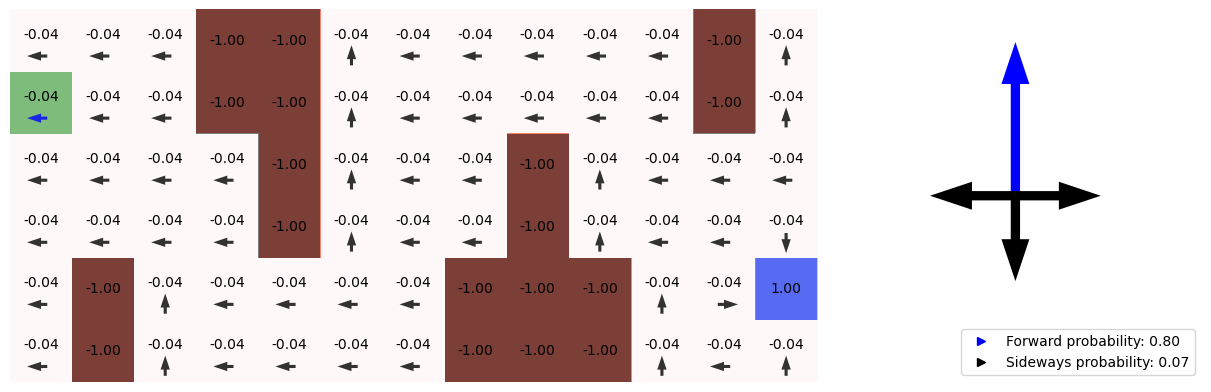

In [7]:
visualizer.iteration_plot(iteration=1,
                          obstacle_reward=-1.0,
                          finish_reward=1.0,
                          empty_reward=-0.04,
                          forward_prob=0.8,
                          gamma=0.9,
                          epsilon=1e-3)

Let's tweak with different hyperparameters - first of all - we can adjust our gamma value to be higher, making agent to be more motivated go into the danger.

gamma <- 0.95

making our agent more motivated we see that it immediately is eager to risk and go into danger, we acquire proper policy, which leads to the finish terminal state. But is also seems it it is not so concerned with obstacles and do not tries to keep some distance from them. 

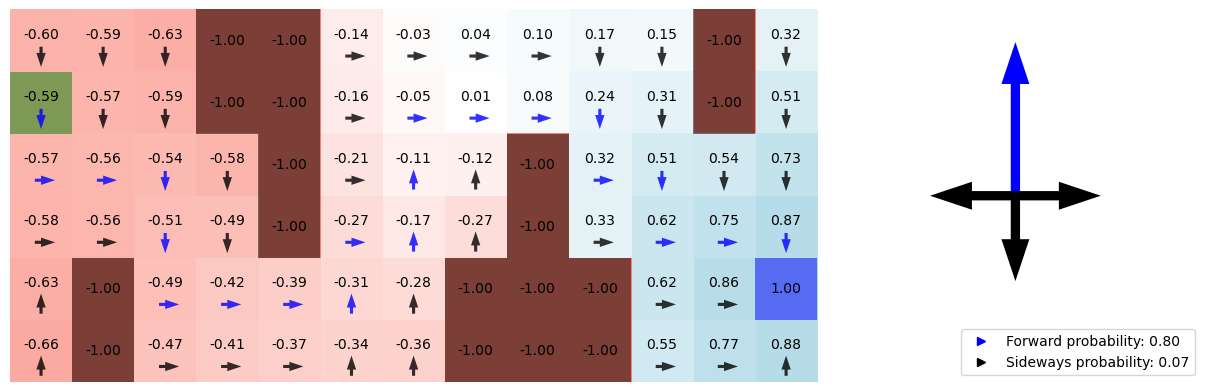

In [9]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.8,
                             'gamma': 0.9500000000000002,
                             'iteration': 48,
                             'obstacle_reward': -1.0})

Let's make our drone less certain with its stability:
forward_prob <- 0.65

This means that when it takes move forwad, there is 35% chance that it will make sidemove instead.

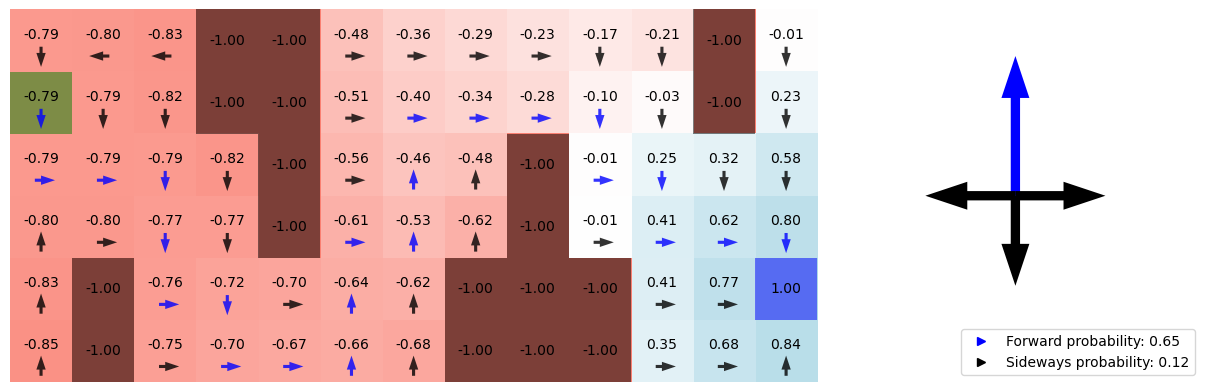

In [11]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.65,
                             'gamma': 0.9500000000000002,
                             'iteration': 84,
                             'obstacle_reward': -1.0}
                          )

We see, that now it keeps some distance from the first stalagtite, but does not keeps the distance with the second stalagmie, becuase the reward is so close and making longer move upward will be less rewarding. 

Let's make moving in cells less harmfull.

empty_reward <- 0.00

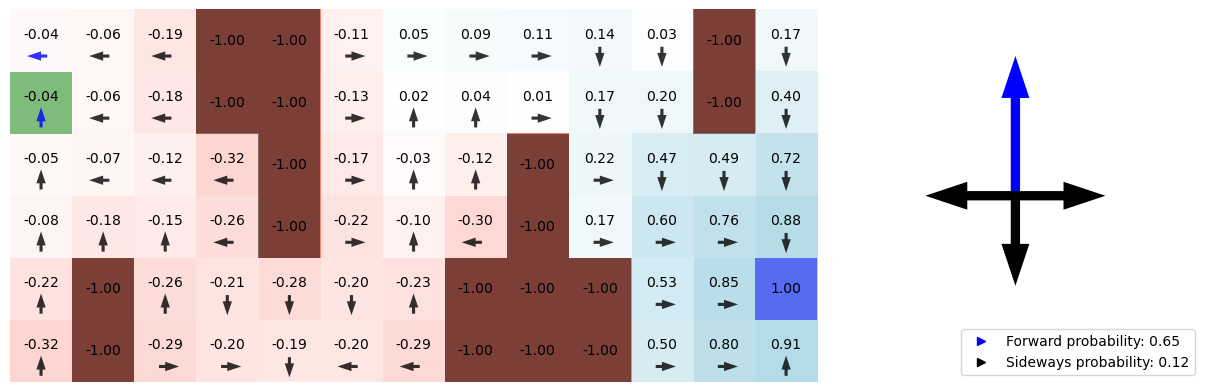

In [12]:
visualizer.iteration_plot(**{'empty_reward': 0.0,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.65,
                             'gamma': 0.9500000000000002,
                             'iteration': 78,
                             'obstacle_reward': -1.0}
                          )

Well, now it is again scared to approach obstacles, lets make more motivation by assigning gamma to -1.0, meaning we have purely additive rewards and no discount.
gamma <- 1.0

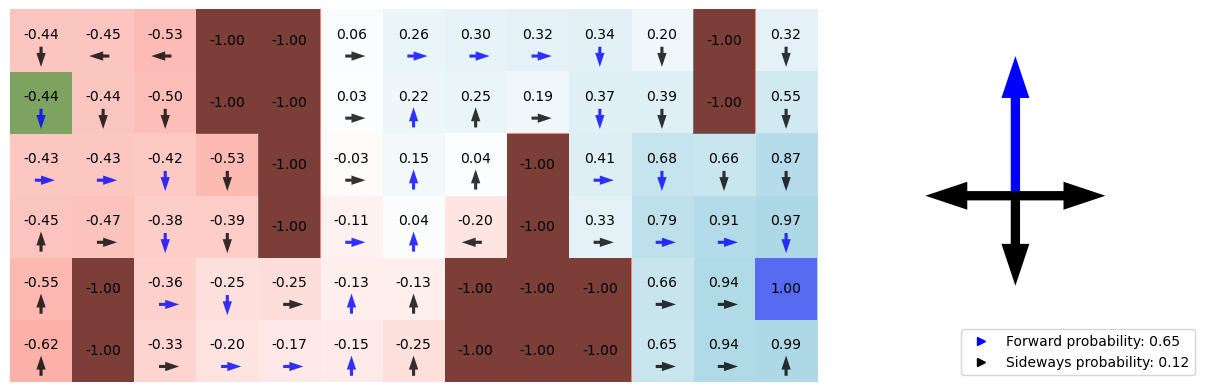

In [13]:
visualizer.iteration_plot(**{'empty_reward': 0.0,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.65,
                             'gamma': 1.0,
                             'iteration': 372,
                             'obstacle_reward': -1.0}
                          )



Now we see, that our agent really wants to get to the finish state reward, and staying in the empty air does no pain, so the agent tries to prefer safer route - keeping its distance from obstacles, and still reaching the finish state!

Let's now return penalty for moving:

empty_reward <- -0.04

Let's make our agent be stable:

forward_prob <- 1.0

This means that drone is 100% sure that his movements are stable and always will be in chose direction. So the drone will not look at all what happens behind, to the up or down of him - because it is sure it will go forward in the chose direction each time.

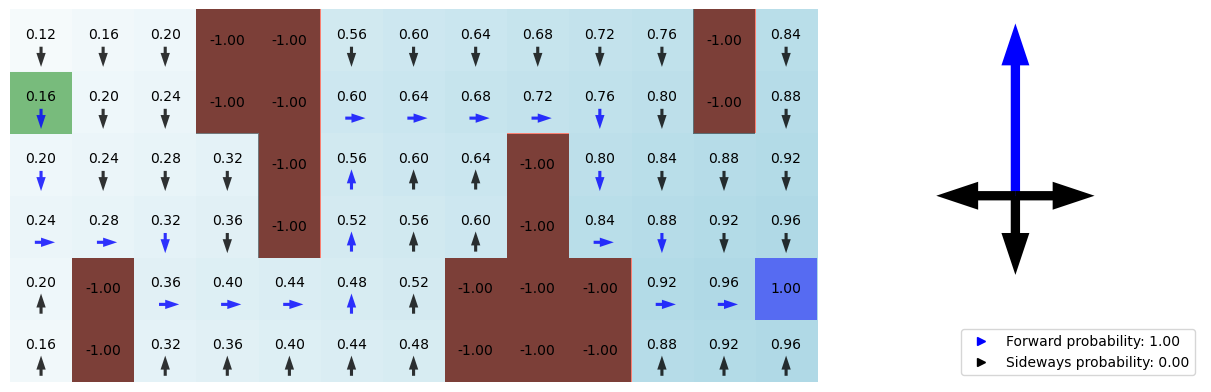

In [14]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 1e-06,
                             'finish_reward': 1.0,
                             'forward_prob': 1.0,
                             'gamma': 1.0,
                             'iteration': 24,
                             'obstacle_reward': -1.0}
                          )

We see it takes the shortest possible path to get to the rewarding terminal state, and it completely neglects the fact that there are obstacles around him, it is sure it will not bump into it by an accident.